# Install Dependencies

## External Dependencies

In [1]:
!pip install seaborn matplotlib


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


## FrostAura Dependencies

In [2]:
import os
import sys

USE_LOCAL_CODE: bool = True # NOTE: When changing this configuration, be sure to restart the interpreter in order to have sys path updates reflect.
directories_to_move_up: int = 2
current_executing_path: str = os.getcwd()
current_executing_path = current_executing_path.replace('\\', '/')
root_path: str = '/'.join(current_executing_path.split('/')[:-directories_to_move_up])

# Clean up.
%pip uninstall frostaura -y
sys.path = [p for p in sys.path if p != root_path]

if USE_LOCAL_CODE:
    sys.path.append(root_path)
else:
    %pip install -U --no-cache-dir frostaura

Note: you may need to restart the kernel to use updated packages.


# Import Dependencies

## Logging

In [3]:
import logging

logging.getLogger().disabled = True

## Imports

In [4]:
from frostaura.engines import IAssetProjectionEngine
from frostaura.engines import SimpleAssetProjectionEngine
import pandas as pd
from frostaura.engines import IAssetValuationEngine
from frostaura.engines import FinvizAssetValuationEngine
from frostaura.engines import IAssetCalculationsEngine
from frostaura.engines import SimpleAssetCalculationsEngine
from frostaura.data_access import EasyEquitiesPersonalAssetDataAccess
from frostaura.data_access import IResourcesDataAccess
from frostaura.data_access import EmbeddedResourcesDataAccess
from frostaura.data_access import HtmlResourcesDataAccess
from frostaura.data_access import IPersonalAssetDataAccess
from frostaura.data_access import IPublicAssetDataAccess
from frostaura.data_access import YahooFinanceDataAccess
from frostaura.engines import IVisualizationEngine
from frostaura.engines import FrostAuraVisualizationEngine
from frostaura.models.visualization_types import VisualizationType

# Usage

## Setup

In [5]:
html_data_access: IResourcesDataAccess = HtmlResourcesDataAccess()
resource_data_access: IResourcesDataAccess = EmbeddedResourcesDataAccess()
asset_valuation_engine: IAssetValuationEngine = FinvizAssetValuationEngine(html_data_access=html_data_access)
public_asset_data_access: IPublicAssetDataAccess = YahooFinanceDataAccess()
asset_calculations_engine: IAssetCalculationsEngine = SimpleAssetCalculationsEngine(public_asset_data_access=public_asset_data_access)
personal_asset_data_access: IPersonalAssetDataAccess = EasyEquitiesPersonalAssetDataAccess(resource_data_access=resource_data_access,
                                                                         username=None,
                                                                         password=None)
asset_projection_engine: IAssetProjectionEngine = SimpleAssetProjectionEngine(asset_valuation_engine=asset_valuation_engine,
                                                               public_asset_data_access=public_asset_data_access)
instance: IVisualizationEngine = FrostAuraVisualizationEngine()

## Project for a Single Symbol

In [6]:
n_months: int = 12*30 # 39 year
usd_zar_exchange_rate: float = 16.17
symbol: str = 'AAPL'
holdings: pd.DataFrame = personal_asset_data_access.get_personal_transactions()
holdings_with_profits: pd.DataFrame = asset_calculations_engine.calculate_holdings_profits(holdings=holdings)
initial_value: float = holdings_with_profits.loc[holdings_with_profits['symbol'] == 'AAPL']['total_current_usd'].sum()
monthly_deposit: float = 2000 / usd_zar_exchange_rate / len(holdings_with_profits)

growth: pd.DataFrame = asset_projection_engine.project_monthly_asset_growth(n_months=n_months,
                                                             symbol=symbol,
                                                             principal_value=initial_value,
                                                             monthly_deposit=monthly_deposit).reset_index()

growth

,month,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
0,0,0.000000,0.000000,0.000000,0.000000,75.312224
1,1,30.921459,0.616933,30.921459,0.616933,106.850616
2,2,30.921459,0.875285,61.842919,1.492217,138.647361
3,3,30.921459,1.156165,92.764378,2.648382,170.724985
4,4,30.921459,1.398522,123.685838,4.046904,203.044967
...,...,...,...,...,...,...
356,356,30.921459,546.829016,11008.039579,56248.703816,67332.055620
357,357,30.921459,561.474530,11038.961039,56810.178347,67924.451610
358,358,30.921459,556.414466,11069.882498,57366.592813,68511.787535
359,359,30.921459,561.225726,11100.803958,57927.818539,69103.934721


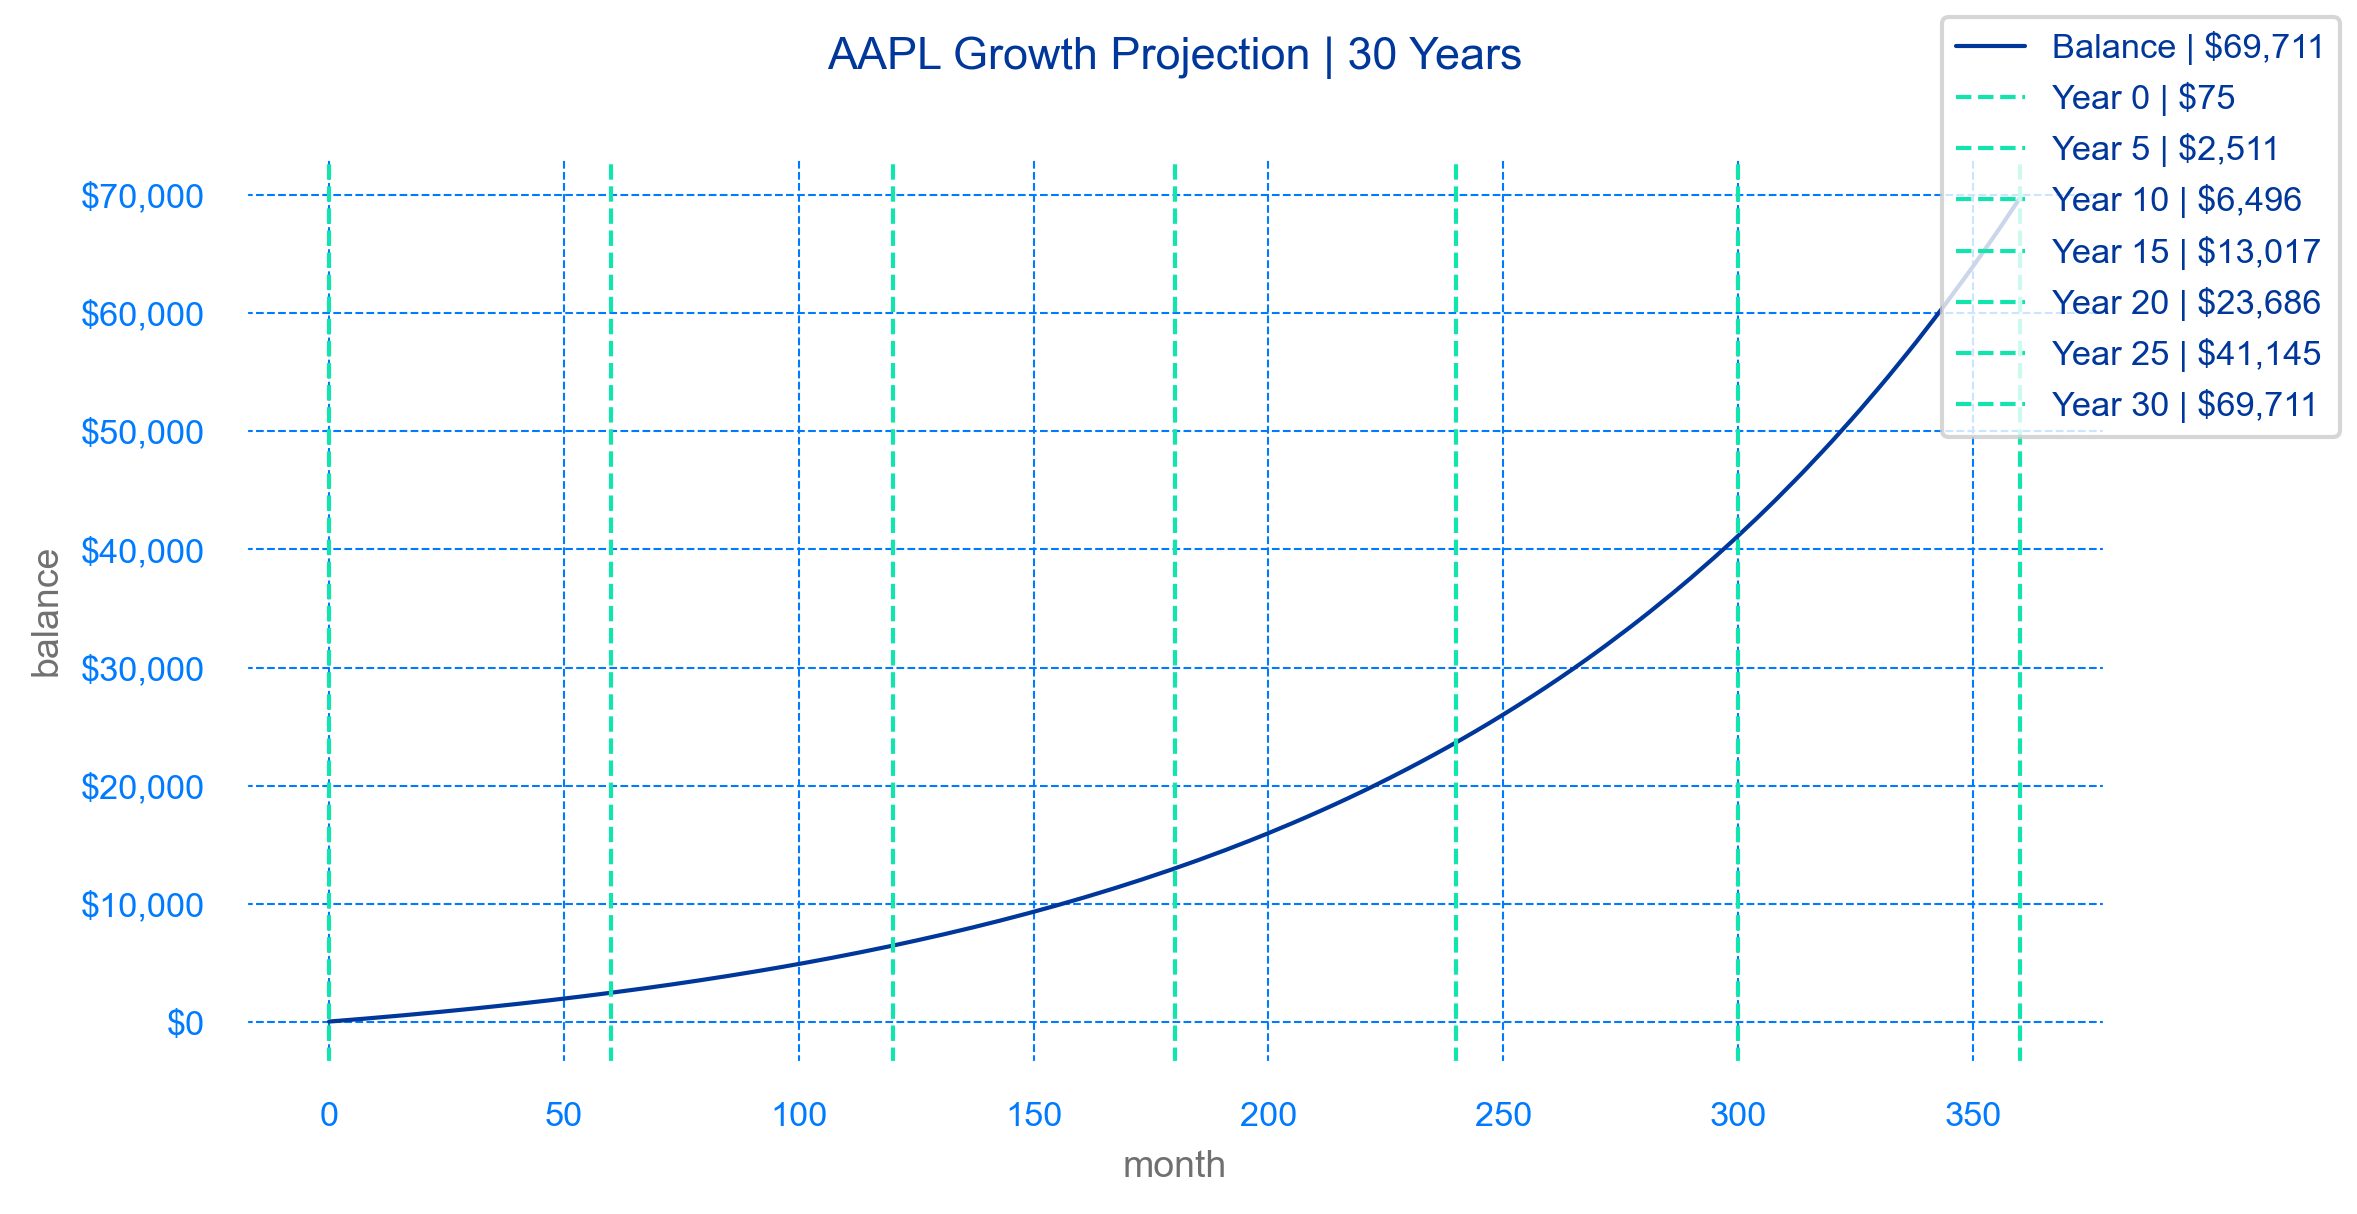

In [7]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='month',
                              y='balance',
                              data=growth,
                              graph_type=VisualizationType.LINE,
                              title=f'{symbol} Growth Projection | 30 Years',
                              legend=True,
                              line_label=f'Balance | {currency_format.format(x=growth.iloc[-1]["balance"])}',
                              y_tick_format_str=currency_format)

for i, r in growth.iterrows():
    # Draw a line for every 5 year.
    if r['month'] % (12 * 5) == 0:
        year: int = int(r['month'] / 12)
        ax.axvline(x=r['month'], linestyle='--', color='#11E5AD', label=f'Year {year} | {currency_format.format(x=r["balance"])}')

fig.legends = [fig.legend()]

## Project Portfolio Asset Ratios (Pie Chart)

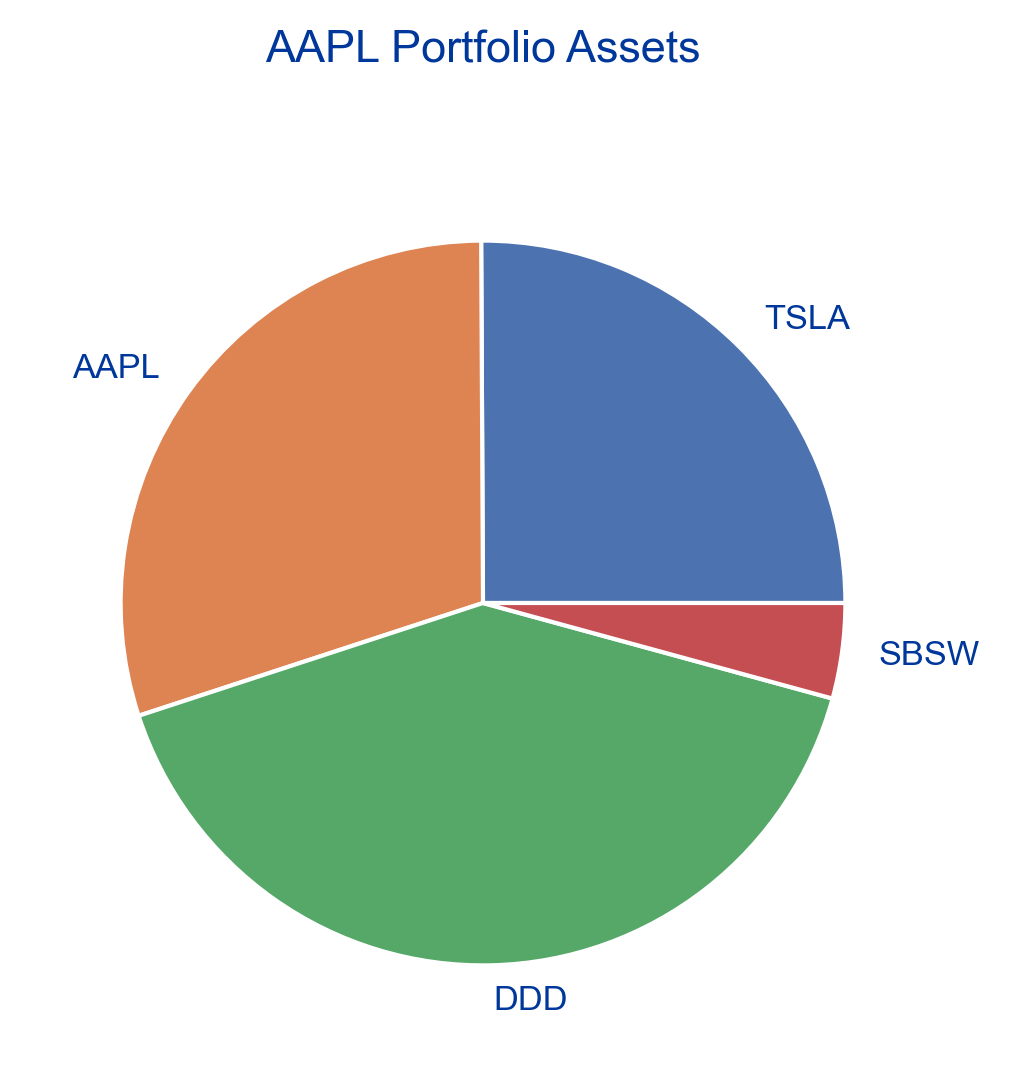

In [8]:
holdings: pd.DataFrame = personal_asset_data_access.get_personal_transactions()
holdings_profits: pd.DataFrame = asset_calculations_engine.calculate_holdings_profits(holdings=holdings)
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='symbol',
                              y='total_current_usd',
                              data=holdings_profits,
                              graph_type=VisualizationType.PIE,
                              title=f'{symbol} Portfolio Assets')

## Project for a Entire Holdings (Multiple Symbols)

In [9]:
# 30 years
n_months: int = 12*30
usd_zar_exchange_rate: float = 16.17
holdings: pd.DataFrame = personal_asset_data_access.get_personal_transactions()
holdings_with_profits: pd.DataFrame = asset_calculations_engine.calculate_holdings_profits(holdings=holdings)
# Simply R 1000 converted to USD and split evenly among how many assets are held.
monthly_deposits: list = [(2000 / usd_zar_exchange_rate / len(holdings_with_profits)) for h in holdings_with_profits]
holdings_growth = asset_projection_engine.project_monthly_holdings_growth(n_months=n_months,
                                                           holdings_with_profits=holdings_with_profits,
                                                           monthly_deposits=monthly_deposits)

holdings_growth

,month,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
0,1,123.685838,0.023075,123.685838,5.938107e+00,3.810205e+02
1,2,123.685838,0.022054,247.371676,1.453053e+01,5.132988e+02
2,3,123.685838,0.021640,371.057514,2.588399e+01,6.483381e+02
3,4,123.685838,0.021379,494.743352,4.004740e+01,7.861873e+02
4,5,123.685838,0.021271,618.429190,5.713397e+01,9.269597e+02
...,...,...,...,...,...,...
355,356,123.685838,0.041393,44032.158318,2.738384e+09,2.738428e+09
356,357,123.685838,0.041394,44155.844156,2.856634e+09,2.856678e+09
357,358,123.685838,0.041395,44279.529994,2.979994e+09,2.980038e+09
358,359,123.685838,0.041396,44403.215832,3.108684e+09,3.108728e+09


In [10]:
(holdings_growth.iloc[12*5]['balance'] - holdings_growth.iloc[0]['balance']) / holdings_growth.iloc[0]['balance'] * 100

4903.756057827745

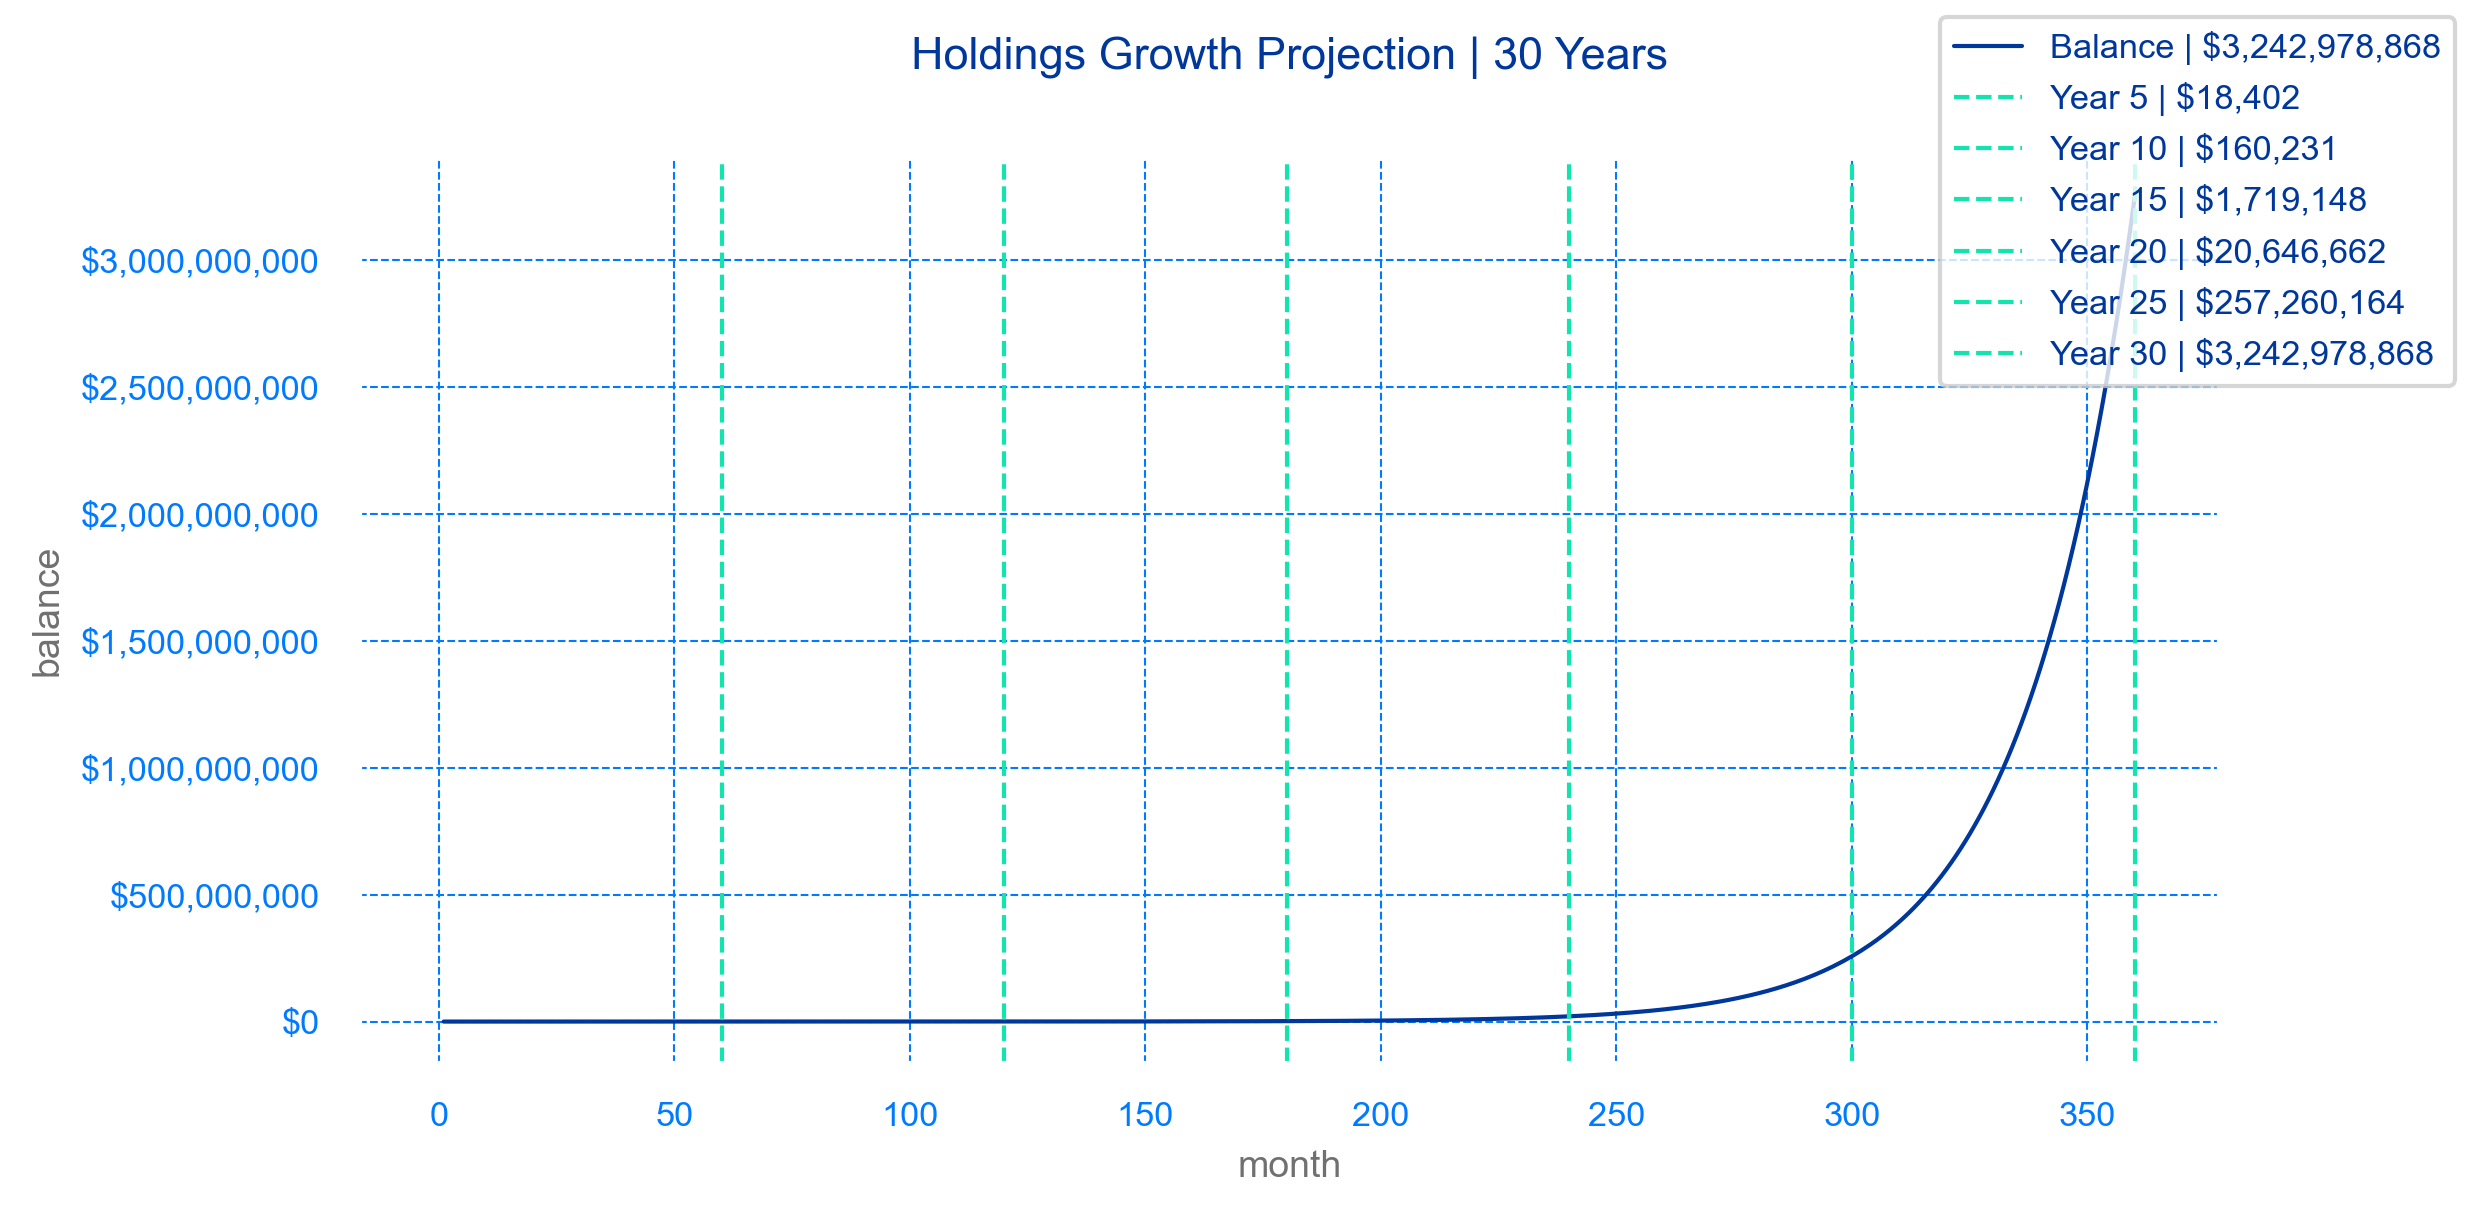

In [11]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='month',
                              y='balance',
                              data=holdings_growth,
                              graph_type=VisualizationType.LINE,
                              title='Holdings Growth Projection | 30 Years',
                              legend=True,
                              line_label=f'Balance | {currency_format.format(x=holdings_growth.iloc[-1]["balance"])}',
                              y_tick_format_str=currency_format)

for i, r in holdings_growth.iterrows():
    # Draw a line for every 5 year.
    if r['month'] % (12 * 5) == 0:
        year: int = int(r['month'] / 12)
        ax.axvline(x=r['month'], linestyle='--', color='#11E5AD', label=f'Year {year} | {currency_format.format(x=r["balance"])}')

fig.legends = [fig.legend()]

## Project Wealth Over Months

In [12]:
monthly_zar_deposit: float = 2000
usd_zar_exchange_rate: float = 16.17
monthly_deposits: list = [(monthly_zar_deposit / usd_zar_exchange_rate / len(holdings_with_profits)) for h in holdings_with_profits]
wealth_projection = asset_projection_engine.project_wealth_growth(holdings_with_profits=holdings_with_profits,
                                                                  monthly_deposits=monthly_deposits,
                                                                  n_months=12*30)

wealth_projection

,Target Balance (USD),Target Balance Eng (USD),ETA (Months),ETA (Years)
0,1.071077e+03,one thousand and seventy-one point zero seven ...,5,0.416667
1,1.025459e+04,"ten thousand, two hundred and fifty-four point...",43,3.583333
2,1.022333e+05,"one hundred and two thousand, two hundred and ...",107,8.916667
3,1.014046e+06,"one million, fourteen thousand and forty-five ...",166,13.833333
4,1.015114e+07,"ten million, one hundred and fifty-one thousan...",222,18.500000
5,1.018059e+08,"one hundred and one million, eight hundred and...",277,23.083333
6,1.036007e+09,"one billion, thirty-six million, seven thousan...",332,27.666667


In [13]:
wealth_projection['Target Balance (USD)'] = wealth_projection['Target Balance (USD)'].apply(lambda v: int(v))
wealth_projection['ETA (Years)'] = wealth_projection['ETA (Years)'].apply(lambda v: int(v))

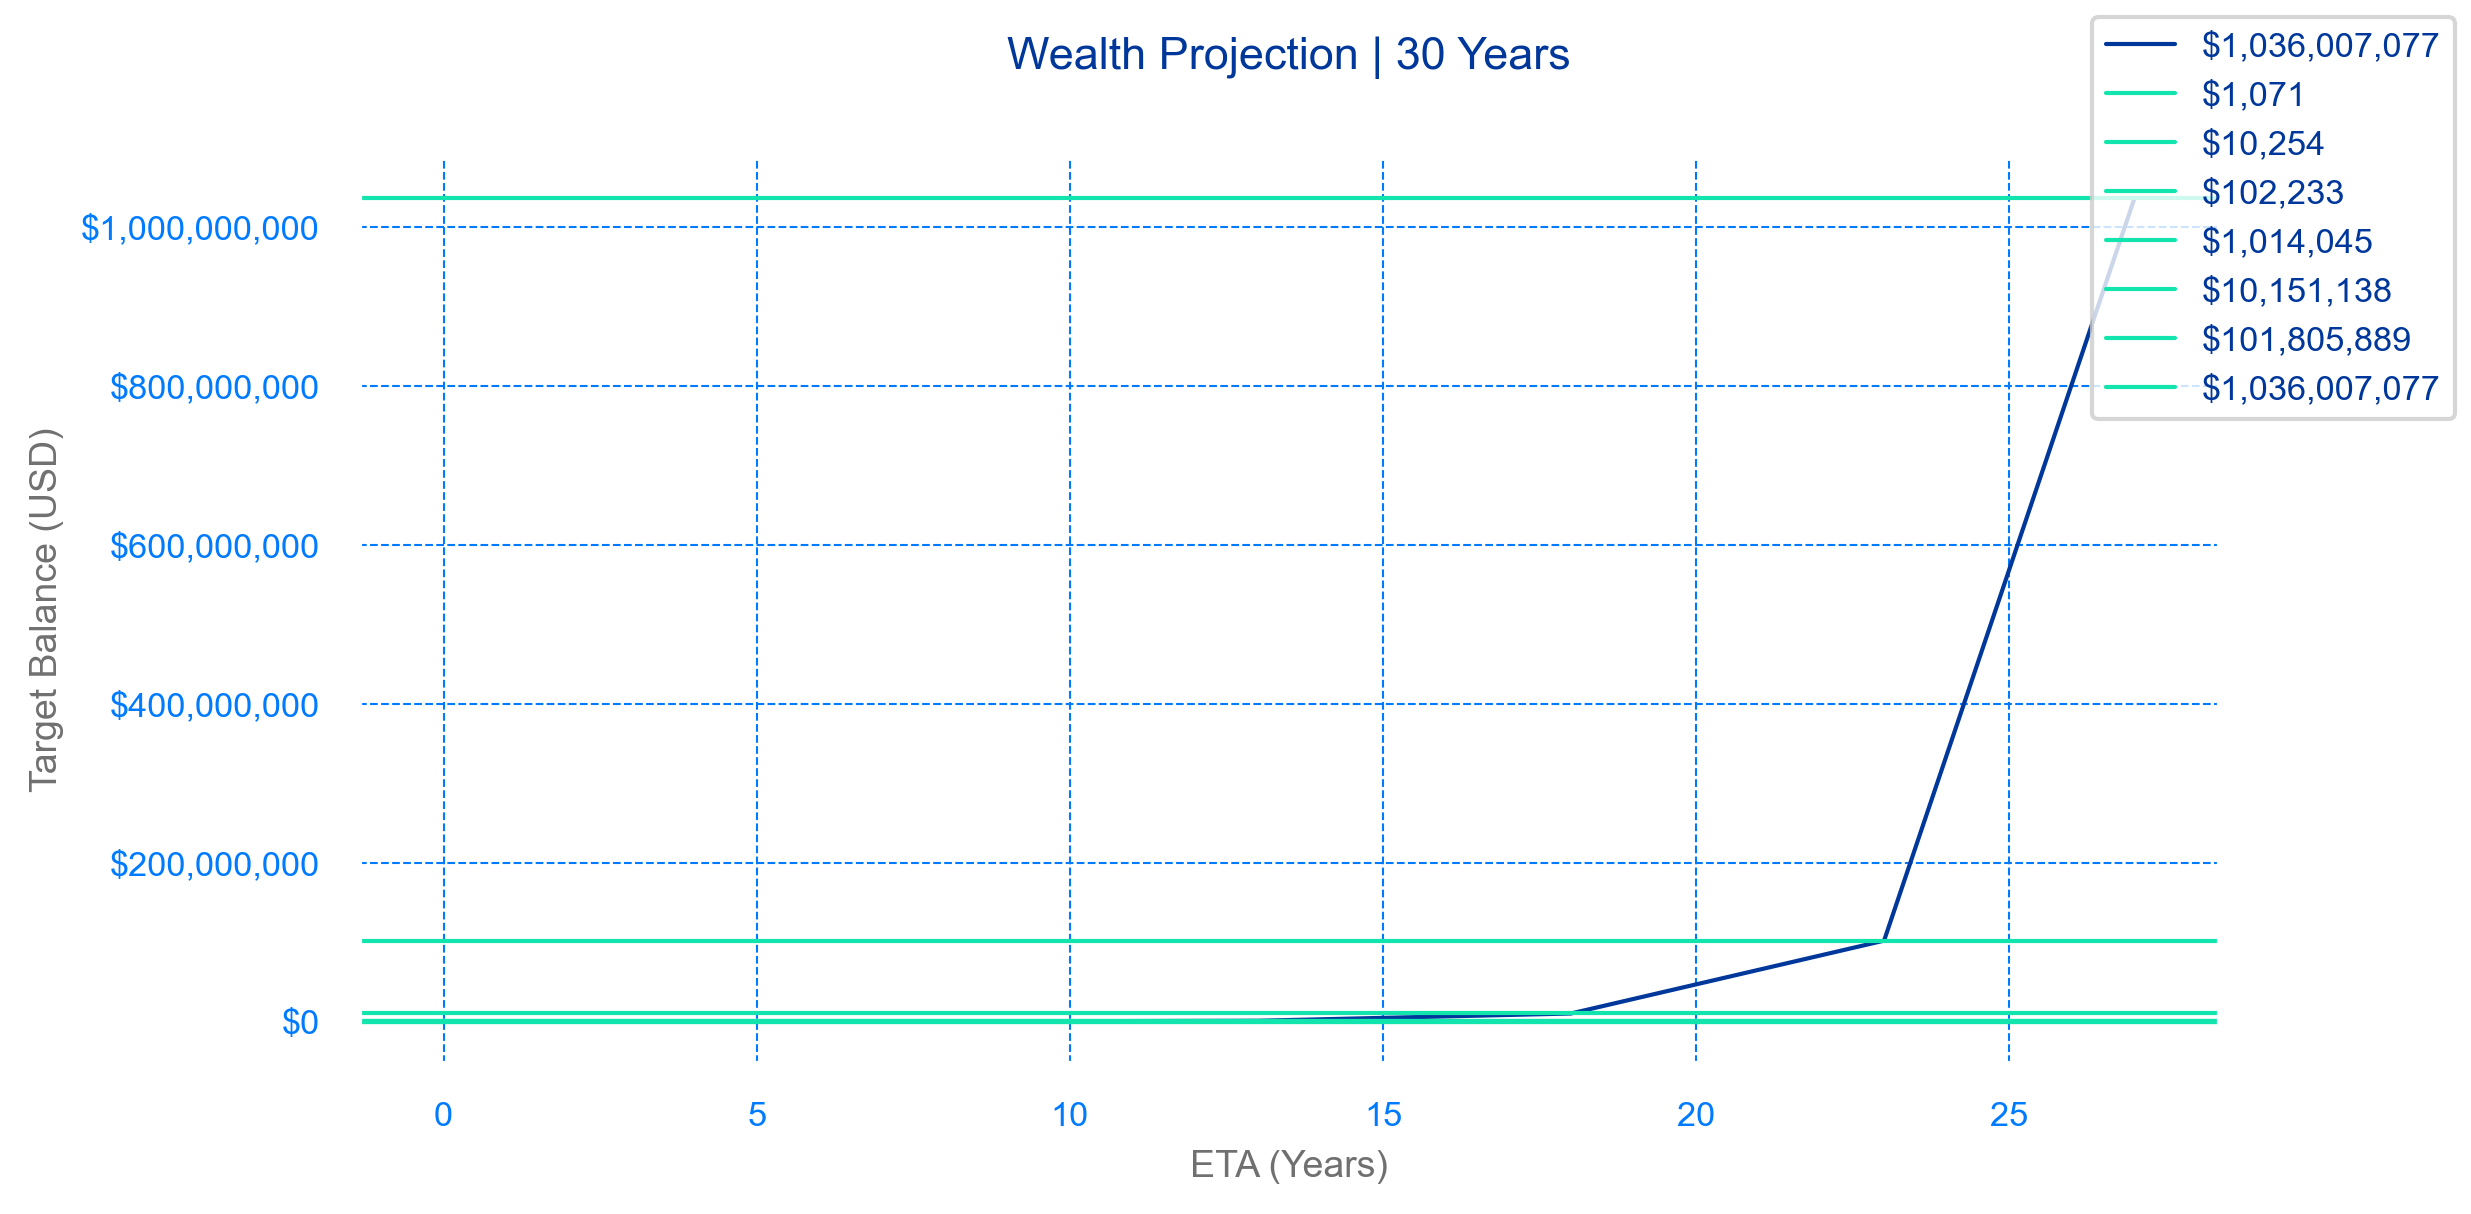

In [14]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='ETA (Years)',
                              y='Target Balance (USD)',
                              data=wealth_projection,
                              graph_type=VisualizationType.LINE,
                              title='Wealth Projection | 30 Years',
                              legend=True,
                              line_label=wealth_projection.iloc[-1]['Target Balance (USD)'],
                              y_tick_format_str=currency_format)

for i, r in wealth_projection.iterrows():
    ax.axhline(y=r['Target Balance (USD)'], linestyle='-', color='#11E5AD', label=currency_format.format(x=r['Target Balance (USD)']))

fig.legends = [fig.legend()]